In [1]:
options(warn = -1, tidyverse.quiet = T)

library(tidyverse, warn.conflicts = F, quietly = T)
library(arrow, warn.conflicts = F)
library(cowplot, warn.conflicts = F)
library(yardstick, warn.conflicts = F)
suppressPackageStartupMessages(library(ggmanh, warn.conflicts = F))
suppressPackageStartupMessages(library(hudson, warn.conflicts = F))
library(scattermore)

# Load data

In [2]:
raw_comparison_df <- read_parquet("data/gwas_comparison.parquet") %>%
    mutate(
        chromosome = ID %>% 
            str_extract("^.+(?=:)") %>% 
            as.double %>% 
            factor(levels = c(1:22)),
        position = ID %>% str_extract("(?<=:).+$") %>% as.double,
    )

raw_comparison_df %>% head(2)

mega_type,ID,P_mega,truth,phenotype_id,P,estimate,chromosome,position
<fct>,<chr>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>
Any,11:100009976,0.3977,FALSE,MaxGCP (N=350k),0.254002,FALSE,11,100009976
Any,11:100009976,0.3977,FALSE,MaxGCP (N=15k),0.872896,FALSE,11,100009976


# Manhattan plots

In [3]:
options(repr.plot.width = 6, repr.plot.height = 3, repr.plot.res = 250)

megastroke_plot <- raw_comparison_df %>%
    filter(mega_type == "Any", phenotype_id == "MaxGCP (N=350k)") %>%
    manhattan_plot(pval.colname = "P_mega", chr.colname = "chromosome", pos.colname = "position")

maxgcp_full_plot <- raw_comparison_df %>%
    filter(mega_type == "Any", phenotype_id == "MaxGCP (N=350k)") %>%
    manhattan_plot(pval.colname = "P", chr.colname = "chromosome", pos.colname = "position")

naive_full_plot <- raw_comparison_df %>%
    filter(mega_type == "Any", phenotype_id == "Naive (N=350k)") %>%
    manhattan_plot(pval.colname = "P", chr.colname = "chromosome", pos.colname = "position")

maxgcp_sub_plot <- raw_comparison_df %>%
    filter(mega_type == "Any", phenotype_id == "MaxGCP (N=15k)") %>%
    manhattan_plot(pval.colname = "P", chr.colname = "chromosome", pos.colname = "position")

naive_sub_plot <- raw_comparison_df %>%
    filter(mega_type == "Any", phenotype_id == "Naive (N=15k)") %>%
    manhattan_plot(pval.colname = "P", chr.colname = "chromosome", pos.colname = "position")

Coordinate system already present. Adding new coordinate system, which will replace the existing one.


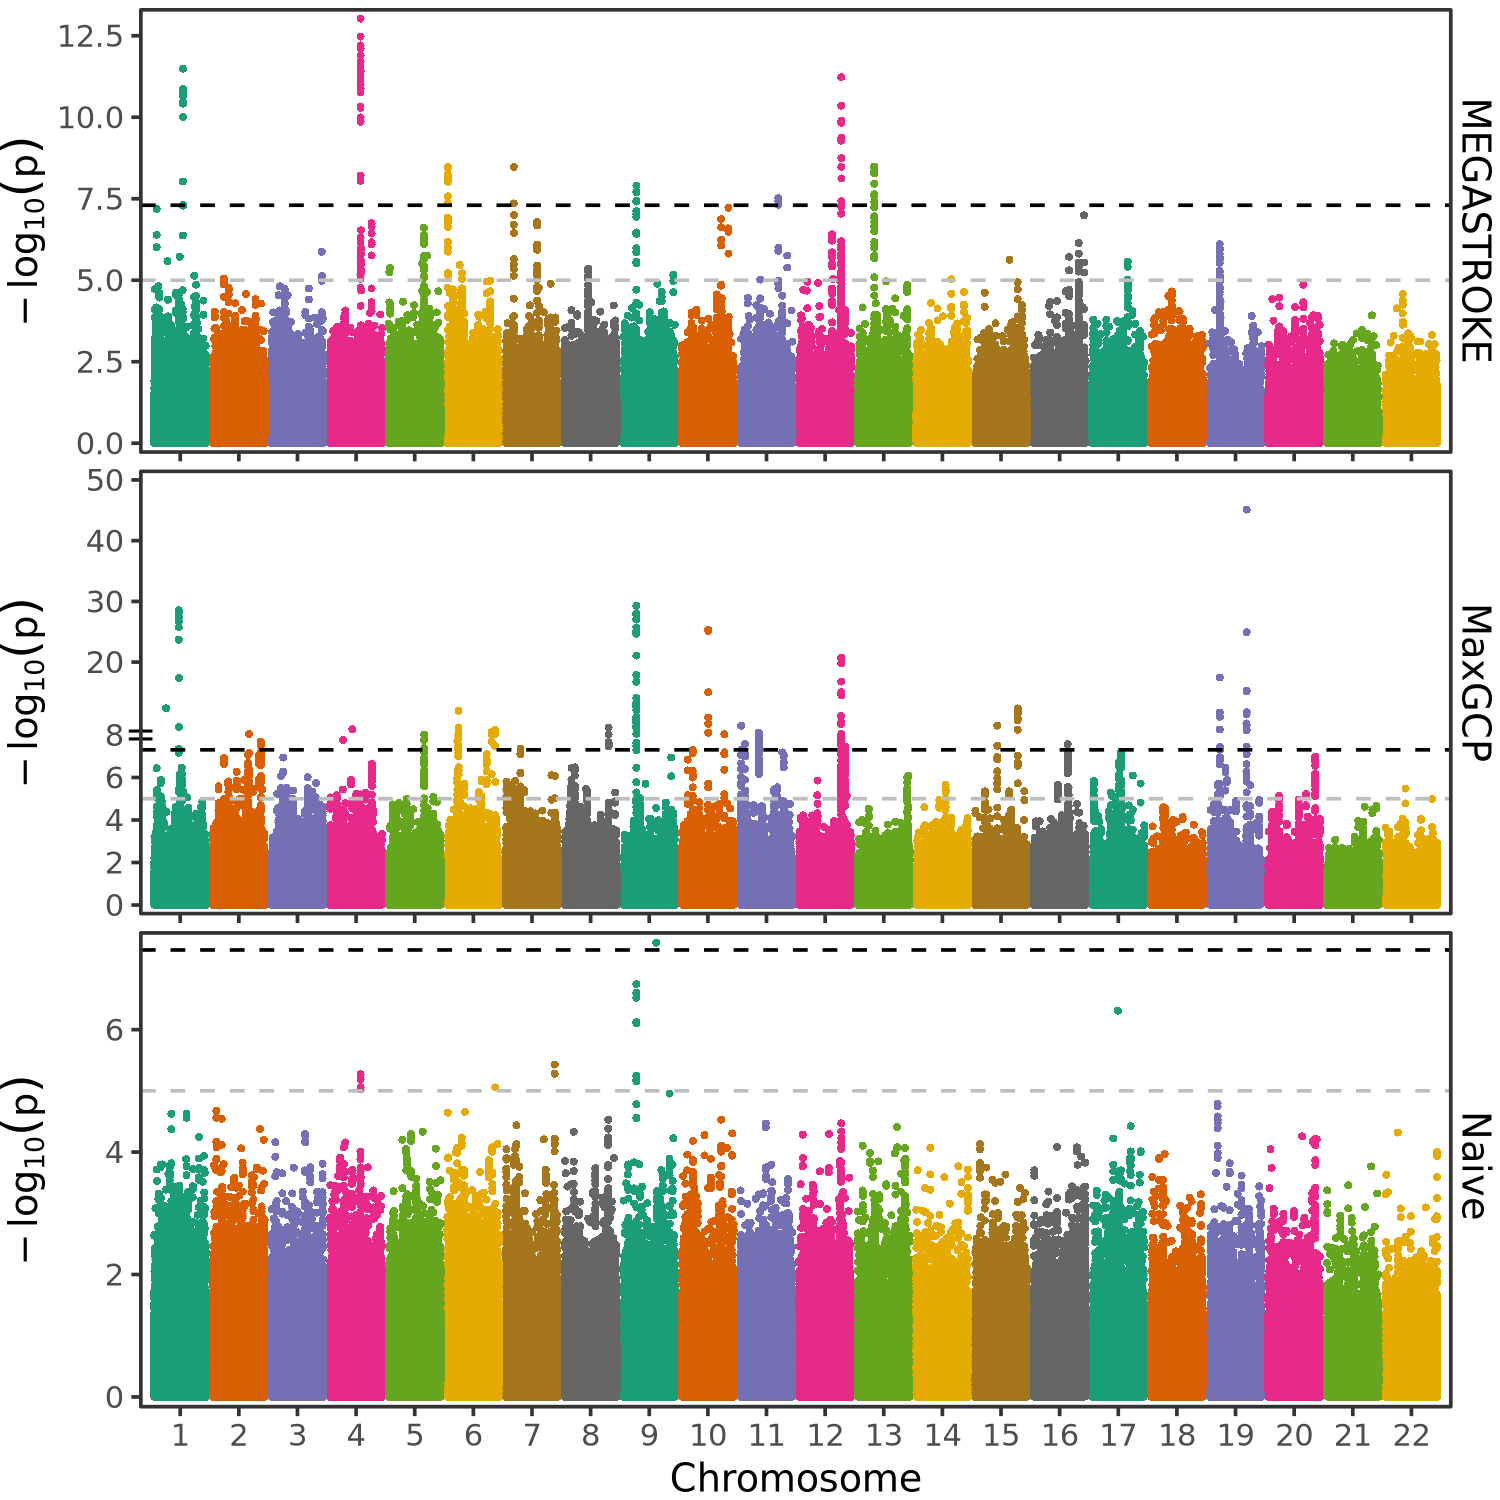

In [4]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 250)

combined_manhattan_plot <- plot_grid(
    megastroke_plot +
        annotate(geom = "text", x = Inf, y = 0, angle = 270, hjust = 1.3, vjust = -0.4, label = "MEGASTROKE") +
        coord_cartesian(clip = "off") +
        theme(
            axis.text.x = element_blank(),
            axis.title.x = element_blank(),
            plot.margin = margin(0.1, 0.5, 0, 0, "cm")
        ),
    maxgcp_full_plot +
        annotate(geom = "text", x = Inf, y = 0, angle = 270, hjust = 1.9, vjust = -0.4, label = "MaxGCP") +
        coord_cartesian(clip = "off") +
        theme(
            axis.text.x = element_blank(),
            axis.title.x = element_blank(),
            plot.margin = margin(0.1, 0.5, 0, 0, "cm")
        ),
    naive_full_plot +
        annotate(geom = "text", x = Inf, y = 0, angle = 270, hjust = 2.6, vjust = -0.4, label = "Naive") +
        coord_cartesian(clip = "off") +
        theme(
            plot.margin = margin(0.1, 0.5, 0, 0, "cm")
        ),
    align = "v",
    ncol = 1,
    rel_heights = c(1, 1, 1.25)
)

save_plot("img/combined_manhattan.png", combined_manhattan_plot, base_height = 6, base_width = 6, 
          dpi = 400, bg = "white")

combined_manhattan_plot

# "Hudson" plots

In [5]:
raw_comparison_df %>% head(2)

mega_type,ID,P_mega,truth,phenotype_id,P,estimate,chromosome,position
<fct>,<chr>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>
Any,11:100009976,0.3977,FALSE,MaxGCP (N=350k),0.254002,FALSE,11,100009976
Any,11:100009976,0.3977,FALSE,MaxGCP (N=15k),0.872896,FALSE,11,100009976


# P-values vs P-values directly

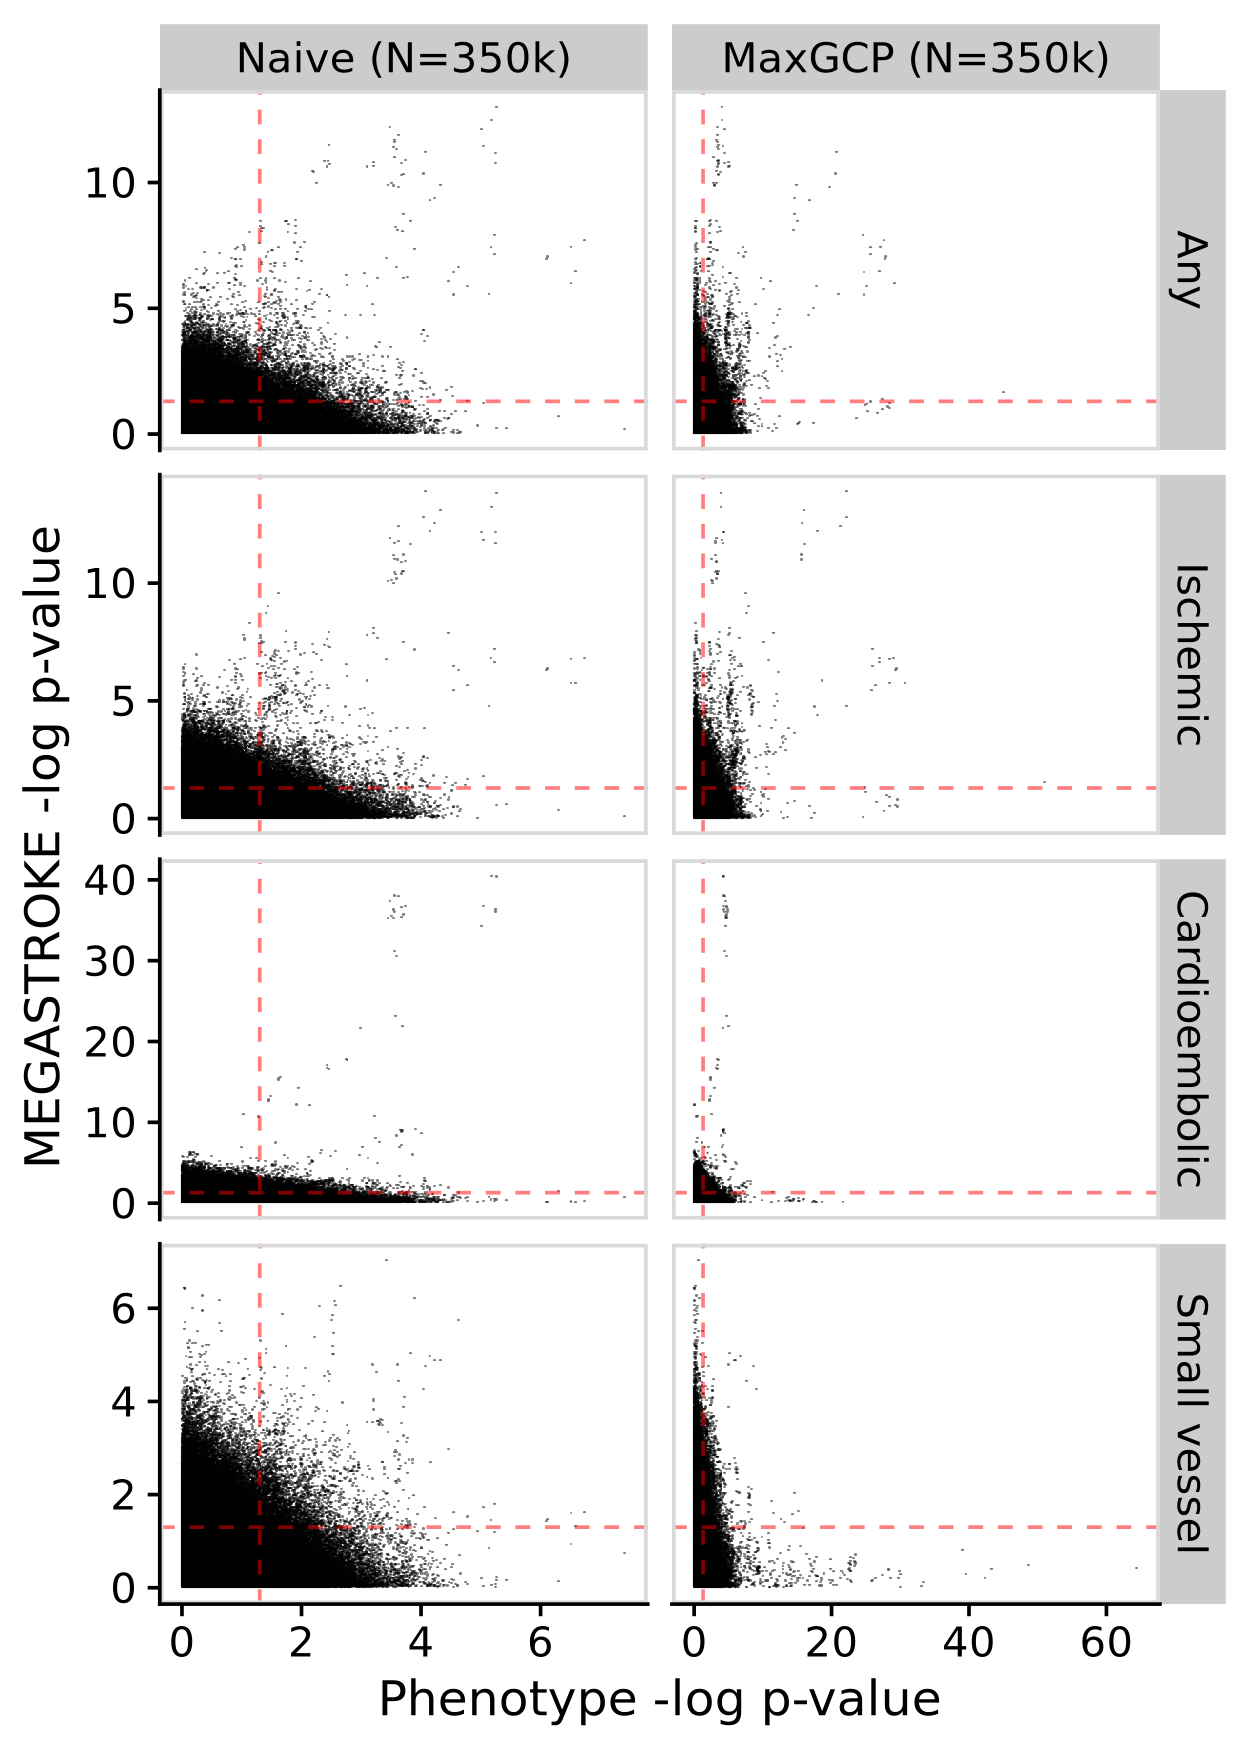

In [6]:
options(repr.plot.width = 5, repr.plot.height = 7, repr.plot.res = 250)

raw_comparison_df %>%
    filter(mega_type != "Large artery", phenotype_id %>% str_detect("350")) %>%
    mutate(
        across(c(P, P_mega), ~-log10(.)),
        phenotype_id = phenotype_id %>%
            factor(levels = c("Naive (N=350k)", "MaxGCP (N=350k)"))
    ) %>%
    ggplot(aes(x = P, y = P_mega)) +
    geom_scattermore(alpha = 0.5, pointsize = 2.1) +
    geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "red", alpha = 0.5) +
    geom_vline(xintercept = -log10(0.05), linetype = "dashed", color = "red", alpha = 0.5) +
    facet_grid(vars(mega_type), vars(phenotype_id), scales = "free") +
    theme_cowplot() +
    panel_border() +
    xlab("Phenotype -log p-value") +
    ylab("MEGASTROKE -log p-value")